In [1]:
#Libraries used
import pandas as pd
import numpy as np
import fileinput
import time
import re
import string
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import tokenize

from textblob import TextBlob

import scipy
from scipy.stats import uniform

#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from imblearn.over_sampling import SMOTE

stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
w_tokenizer = tokenize.WhitespaceTokenizer()

# Remove newline
def remove_nline(value):
    return ''.join(str(value).splitlines())

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if not w in set(stopwords)])

# Load the Dataset

In [3]:
data = pd.read_excel('raw_new_posts_from_SD.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subreddit             4943 non-null   object 
 1   title                 4943 non-null   object 
 2   selftext              3913 non-null   object 
 3   upvote_ratio          4943 non-null   float64
 4   author                4943 non-null   object 
 5    author_flair_text    1411 non-null   object 
 6   ups                   4943 non-null   int64  
 7   downs                 4943 non-null   int64  
 8   score                 4943 non-null   int64  
 9   kind                  4943 non-null   object 
 10  id                    4943 non-null   object 
 11  link_flair_css_class  1709 non-null   object 
 12  created_utc           4943 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 502.1+ KB


# Preprocess Dataset

In [4]:
#Create Alcoholic Post & Label as 1

df = data
df[" author_flair_text"] = data[" author_flair_text"].replace("\sdays||\sday","",regex=True)

#Convert badge to float dtype
df = df.astype({" author_flair_text": 'float32'})

#If get post from SD subreddit and has abstained for less than a year
testdf= df[(df['subreddit'] == 'stopdrinking') & (df[' author_flair_text'] <= 365)]

#Combine title and post
testdf['selftext'] = testdf['title'] + " " +testdf['selftext']
testdf['selftext'] = [remove_nline(i) for i in testdf['selftext']]

# Remove most punctuations except !?,.' , these are needed for sentence spliting
testdf["selftext"]: list[str] = [str(x).translate(str.maketrans('', '', '"#$%&\()*+-/:;<=>@[\\]^_`{|}~')) for x in testdf["selftext"]]

#Break posts into list of sentences, cannot use "post" since it removes punctuation 
testdf['s_selftext'] = [tokenize.sent_tokenize(str(i), language="english") for i in testdf['selftext']]

# Create observations for each sentence
newtestdf = testdf.explode('s_selftext') 

#Get subjectivity score for each sentence
newtestdf['subjectivity'] = [TextBlob(str(i)).sentiment.subjectivity for i in newtestdf['s_selftext']]


#new rows of labels split by sentences and calculate their subjectivity
cols = ['subreddit', 's_selftext', 'subjectivity']
target_df = newtestdf[cols]

#Only use post where subjectivity is more than 0.1
target_df= target_df[target_df['subjectivity'] >= 0.1]

# Label alcolic post as 1
target_df['label'] = 1

C:\Users\User\AppData\Local\Temp\ipykernel_14268\2810795996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['selftext'] = testdf['title'] + " " +testdf['selftext']
C:\Users\User\AppData\Local\Temp\ipykernel_14268\2810795996.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['selftext'] = [remove_nline(i) for i in testdf['selftext']]
C:\Users\User\AppData\Local\Temp\ipykernel_14268\2810795996.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [5]:
#Create Non-Alcoholic Post & Label as 0


df = data
df[" author_flair_text"] = data[" author_flair_text"].replace("\sdays||\sday","",regex=True)

#Convert badge to float dtype
df = df.astype({" author_flair_text": 'float32'})

#Create subset data for non target
ntestdf= df[(df['subreddit'] != 'stopdrinking') | ((df[' author_flair_text'] >= 365) & (df['subreddit'] == 'stopdrinking') )]

 
#Combine title and post
ntestdf['selftext'] = ntestdf['title'] + " " +ntestdf['selftext']
ntestdf['selftext'] = [remove_nline(i) for i in ntestdf['selftext']]

# Remove most punctuations except !?,.', these are needed for sentence spliting
ntestdf["selftext"]: list[str] = [str(x).translate(str.maketrans('', '', '"#$%&\()*+-/:;<=>@[\\]^_`{|}~')) for x in ntestdf["selftext"]]

#Break posts into list of sentences, cannot use "post" since it removes punctuation 
ntestdf['s_selftext'] = [tokenize.sent_tokenize(str(i), language="english") for i in ntestdf['selftext']]

# Create observations for each sentence
nnewtestdf = ntestdf.explode('s_selftext') 

#Get subjectivity score
nnewtestdf['subjectivity'] = [TextBlob(str(i)).sentiment.subjectivity for i in nnewtestdf['s_selftext']]


#new rows of labels split by sentences and calculate their subjectivity
cols = ['subreddit', 's_selftext', 'subjectivity']
ntarget_df = nnewtestdf[cols]

#Only use post where subjectivity is more than 0.1
ntarget_df= ntarget_df[ntarget_df['subjectivity'] >= 0.1]

# Label alcolic post as 1
ntarget_df['label'] = 0

C:\Users\User\AppData\Local\Temp\ipykernel_14268\925545516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntestdf['selftext'] = ntestdf['title'] + " " +ntestdf['selftext']
C:\Users\User\AppData\Local\Temp\ipykernel_14268\925545516.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntestdf['selftext'] = [remove_nline(i) for i in ntestdf['selftext']]
C:\Users\User\AppData\Local\Temp\ipykernel_14268\925545516.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [6]:
#Combining labels into input
frames = [target_df,ntarget_df]

input = pd.concat(frames)

In [7]:
input['s_selftext'] = input['s_selftext'].apply(str.lower)

# Remove all punction
input['s_selftext']: list[str] = [re.sub('[^a-zA-Z]', ' ', x) for x in input['s_selftext']]

#Lemmatize post 
input['lemmatized_text'] = input.s_selftext.apply(lemmatize_text)

X = input['lemmatized_text']
Y = input['label']

# Stratify the split by the target label so that both sets have the balanced cases of both labels
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.25, random_state=0, stratify=Y)

In [8]:
print("Alcoholic post: {alcoholic}\n Non-Alcoholic post: {nalcoholic}".format(alcoholic=len(input[input['label'] == 1]), nalcoholic=len(input[input['label'] == 0])))

Alcoholic post: 6769
 Non-Alcoholic post: 6630


# Feature Extracting using TF IDF Vectorizer
https://www.analyticsvidhya.com/blog/2021/09/creating-a-movie-reviews-classifier-using-tf-idf-in-python/

In [9]:
#tf idf
tf_idf = TfidfVectorizer(ngram_range = (1,3), analyzer='word')
#applying tf idf to training data. Learn vocabulary and idf, return document-term matrix.
X_train_tf = tf_idf.fit_transform(train_X)
#applying tf idf to training data Transform documents to document-term matrix.
#Uses the vocabulary and document frequencies (df) learned by fit (or fit_transform).
X_train_tf = tf_idf.transform(train_X)

print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 10049, n_features: 159796


In [9]:
with open('TFIDF.pkl', 'wb') as file:
    pickle.dump(tf_idf, file)

In [10]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(test_X)
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 3350, n_features: 159796


# SMOTE Oversampling (Not neccessary now, since have balanced target label cases)

In [8]:
print("Before OverSampling, TRAIN counts of label '1': {}".format(sum(train_Y == 1)))
print("Before OverSampling, TRAIN counts of label '0': {} \n".format(sum(train_Y == 0)))

print("Before OverSampling, TEST counts of label '1': {}".format(sum(test_Y == 1)))
print("Before OverSampling, TEST counts of label '0': {} \n".format(sum(test_Y == 0)))

sm = SMOTE(random_state = 2)
X_train_tf, train_Y = sm.fit_resample(X_train_tf, train_Y.ravel())

#X_test_tf, test_Y = sm.fit_resample(X_test_tf, test_Y.ravel())


print('After OverSampling, the shape of train_X: {}'.format(X_train_tf.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(train_Y.shape))

print("After OverSampling, TRAIN counts of label '1': {}".format(sum(train_Y == 1)))
print("After OverSampling, TRAIN counts of label '0': {}".format(sum(train_Y == 0)))

print("After OverSampling, TEST counts of label '1': {}".format(sum(test_Y == 1)))
print("After OverSampling, TEST counts of label '0': {}".format(sum(test_Y == 0)))

Before OverSampling, TRAIN counts of label '1': 2245
Before OverSampling, TRAIN counts of label '0': 689 

Before OverSampling, TEST counts of label '1': 749
Before OverSampling, TEST counts of label '0': 230 

After OverSampling, the shape of train_X: (4490, 509945)
After OverSampling, the shape of train_y: (4490,) 

After OverSampling, TRAIN counts of label '1': 2245
After OverSampling, TRAIN counts of label '0': 2245
After OverSampling, TEST counts of label '1': 749
After OverSampling, TEST counts of label '0': 230


# Naive Bayes Classifier

In [11]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, train_Y)

#predicted y
y_pred = naive_bayes_classifier.predict(X_test_tf)

print(classification_report(test_Y, y_pred, target_names=['Recent Relapse', 'Not Relapse']))

print('\nConfusion matrix:\n True Pos \t False Pos\n False Neg\t True Neg')
print(confusion_matrix(test_Y, y_pred))

print(accuracy_score(test_Y, y_pred))

                precision    recall  f1-score   support

Recent Relapse       0.75      0.64      0.69      1658
   Not Relapse       0.69      0.80      0.74      1692

      accuracy                           0.72      3350
     macro avg       0.72      0.72      0.72      3350
  weighted avg       0.72      0.72      0.72      3350


Confusion matrix:
 True Pos 	 False Pos
 False Neg	 True Neg
[[1059  599]
 [ 346 1346]]
0.7179104477611941


In [12]:
C = np.array([50,10,1,0.1,0.01,0.001,0.0001,0])

params ={
    "alpha": C
}
grid = GridSearchCV(naive_bayes_classifier, params)

grid.fit(X_train_tf, train_Y)
print("Tuned hyperparameter : (Best params)", grid.best_params_)
print("Tuned hyperparameter : (Best score/accuracy)", grid.best_score_)

Tuned hyperparameter : (Best params) {'alpha': 1.0}
Tuned hyperparameter : (Best score/accuracy) 0.7136037086840561


d:\Python\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
d:\Python\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
d:\Python\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
d:\Python\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
d:\Python\lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alph

# Logistic Regression Classifier

In [13]:
logistic_regression_classifier = LogisticRegression()
logistic_regression_classifier.fit(X_train_tf, train_Y)

#predicted y
y_pred = logistic_regression_classifier.predict(X_test_tf)

print(classification_report(test_Y, y_pred, target_names=['Recent Relapse', 'Not Relapse']))

print('\nConfusion matrix:\n True Pos \t False Pos\n False Neg\t True Neg')
print(confusion_matrix(test_Y, y_pred))

print(accuracy_score(test_Y, y_pred))

                precision    recall  f1-score   support

Recent Relapse       0.71      0.69      0.70      1658
   Not Relapse       0.70      0.73      0.72      1692

      accuracy                           0.71      3350
     macro avg       0.71      0.71      0.71      3350
  weighted avg       0.71      0.71      0.71      3350


Confusion matrix:
 True Pos 	 False Pos
 False Neg	 True Neg
[[1140  518]
 [ 456 1236]]
0.7092537313432836


In [15]:
#Hyperparameter Tuning
C = np.array([1,0.1,0.01,0.001,0.0001,0])

params ={
    "C": C,
    "penalty": [None, 'l1', 'l2', 'elasticnet'],
    "solver" : ['newton-cg', 'lbfgs', 'liblinear']

}
grid = GridSearchCV(logistic_regression_classifier, params)

grid.fit(X_train_tf, train_Y)
print("Tuned hyperparameter : (Best params)", grid.best_params_)
print("Tuned hyperparameter : (Best score/accuracy)", grid.best_score_)


d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Python\lib\site-packages\sklear

Tuned hyperparameter : (Best params) {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Tuned hyperparameter : (Best score/accuracy) 0.7069365467337281


'\n\nmodel = LogisticRegression()\nsolvers = [\'newton-cg\', \'lbfgs\', \'liblinear\']\npenalty = [\'l2\']\nc_values = [100, 10, 1.0, 0.1, 0.01]\n# define grid search\ngrid = dict(solver=solvers,penalty=penalty,C=c_values)\n\n\nC = np.array([1,0.1,0.01,0.001,0.0001,0])\nrand_params = {\'C\': C\n            #,     \n}\nseed = 10\niterations = 100\n\n\nrsearch = RandomizedSearchCV(estimator=logistic_regression_classifier\n                                , param_distributions=rand_params\n                                , n_iter=iterations, random_state=seed)\n\n\nrsearch.fit(X_train_tf, train_Y)\nprint("Tuned hyperparameter : (Best params)", rsearch.best_params_)\nprint("Tuned hyperparameter : (Best score/accuracy)", rsearch.best_score_)\nprint(rsearch.best_estimator_.C)\n'

In [14]:
#After Tuning
logistic_regression_classifier = LogisticRegression(C=1.0, penalty= 'l2', solver= 'newton-cg')
logistic_regression_classifier.fit(X_train_tf, train_Y)

#predicted y
y_pred = logistic_regression_classifier.predict(X_test_tf)

print(classification_report(test_Y, y_pred, target_names=['Recent Relapse', 'Not Relapse']))

print('\nConfusion matrix:\n True Pos \t False Pos\n False Neg\t True Neg')
print(confusion_matrix(test_Y, y_pred))

print(accuracy_score(test_Y, y_pred))

                precision    recall  f1-score   support

Recent Relapse       0.71      0.69      0.70      1658
   Not Relapse       0.70      0.73      0.72      1692

      accuracy                           0.71      3350
     macro avg       0.71      0.71      0.71      3350
  weighted avg       0.71      0.71      0.71      3350


Confusion matrix:
 True Pos 	 False Pos
 False Neg	 True Neg
[[1140  518]
 [ 456 1236]]
0.7092537313432836


# Support Vector Classifier

In [15]:
SVC_clf = LinearSVC()
SVC_clf.fit(X_train_tf, train_Y)

#predicted y
y_pred = SVC_clf.predict(X_test_tf)

print(classification_report(test_Y, y_pred, target_names=['Recent Relapse', 'Not Relapse']))

print('\nConfusion matrix:\n True Pos \t False Pos\n False Neg\t True Neg')
print(confusion_matrix(test_Y, y_pred))

print(accuracy_score(test_Y, y_pred))

                precision    recall  f1-score   support

Recent Relapse       0.71      0.69      0.70      1658
   Not Relapse       0.70      0.73      0.72      1692

      accuracy                           0.71      3350
     macro avg       0.71      0.71      0.71      3350
  weighted avg       0.71      0.71      0.71      3350


Confusion matrix:
 True Pos 	 False Pos
 False Neg	 True Neg
[[1142  516]
 [ 462 1230]]
0.7080597014925373


In [19]:
#Hyperparameter Tuning 
C = np.array([50, 10,1,0.1,0.01,0.001,0.0001,0])

params ={
    "C": C,
    "penalty" : ['l1','l2'],
    "loss" : ['hinge', 'square-hinge'],
    "multi_class" : ['ovr' ,'crammer_singer'],
}
grid = GridSearchCV(SVC_clf, params)

grid.fit(X_train_tf, train_Y)
print("Tuned hyperparameter : (Best params)", grid.best_params_)
print("Tuned hyperparameter : (Best score/accuracy)", grid.best_score_)

d:\Python\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Tuned hyperparameter : (Best params) {'C': 1.0, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
Tuned hyperparameter : (Best score/accuracy) 0.7150955030719969


d:\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
215 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "d:\Python\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "d:\Python\lib\site-packag

In [16]:
#After Tuning
SVC_clf = LinearSVC(C=1.0, loss= 'hinge', multi_class= 'ovr', penalty= 'l2')
SVC_clf.fit(X_train_tf, train_Y)

#predicted y
y_pred = SVC_clf.predict(X_test_tf)

print(classification_report(test_Y, y_pred, target_names=['Recent Relapse', 'Not Relapse']))

print('\nConfusion matrix:\n True Pos \t False Pos\n False Neg\t True Neg')
print(confusion_matrix(test_Y, y_pred))

print(accuracy_score(test_Y, y_pred))

                precision    recall  f1-score   support

Recent Relapse       0.73      0.68      0.70      1658
   Not Relapse       0.71      0.75      0.73      1692

      accuracy                           0.72      3350
     macro avg       0.72      0.72      0.72      3350
  weighted avg       0.72      0.72      0.72      3350


Confusion matrix:
 True Pos 	 False Pos
 False Neg	 True Neg
[[1132  526]
 [ 423 1269]]
0.7167164179104477


# Decision Tree Classifier (Takes 30s, and poor performance)

In [12]:
D_clf = DecisionTreeClassifier()
D_clf.fit(X_train_tf, train_Y)

#predicted y
y_pred = D_clf.predict(X_test_tf)

print(classification_report(test_Y, y_pred, target_names=['Recent Relapse', 'Not Relapse']))

print('\nConfusion matrix:\n True Pos \t False Pos\n False Neg\t True Neg')
print(confusion_matrix(test_Y, y_pred))

print(accuracy_score(test_Y, y_pred))

                precision    recall  f1-score   support

Recent Relapse       0.62      0.53      0.57      1658
   Not Relapse       0.60      0.68      0.64      1692

      accuracy                           0.61      3350
     macro avg       0.61      0.60      0.60      3350
  weighted avg       0.61      0.61      0.60      3350


Confusion matrix:
 True Pos 	 False Pos
 False Neg	 True Neg
[[ 872  786]
 [ 537 1155]]
0.6050746268656716


# Saving Models and Coefficients

In [27]:
with open('NBmodel.pkl', 'wb') as file:
    pickle.dump(naive_bayes_classifier, file)

with open('LRmodel.pkl', 'wb') as file:
    pickle.dump(logistic_regression_classifier, file)

with open('SVCmodel.pkl', 'wb') as file:
    pickle.dump(SVC_clf, file) #This is the chosen model

In [29]:
#Getting the feature coefficient df 
columns : list[str] = tf_idf.get_feature_names_out()

LRfeature_coefs = pd.DataFrame(zip(columns, np.transpose(logistic_regression_classifier.coef_)), columns=['features', 'coef'])

In [30]:
#Getting the feature coefficient df 
columns : list[str] = tf_idf.get_feature_names_out()

SVCfeature_coefs = pd.DataFrame(zip(columns, np.transpose(SVC_clf.coef_)), columns=['features', 'coef'])

In [32]:
with open('LRfeature_coefs_df.pkl', 'wb') as file:
    pickle.dump(LRfeature_coefs, file)

with open('SVCfeature_coefs_df.pkl', 'wb') as file:
    pickle.dump(SVCfeature_coefs, file)

# NB does not have get coef attribute

# Doing a test prediction

In [17]:
#doing a test prediction
raw_txt = """

So, I'm over 2 months sober after a couple of years of daily drinking. On some days staying sober is easy, on others not so much. So today, I'm trying to remind myself about all the things I've rediscovered so far.

Milk, damn whole milk in the evening instead of a drink, I forgot how much I like it. 
Chocolate, which I didn't have a taste for in the years I drank. 
Food in the evening has it's own flavour again instead of being muddled by the taste of alcohol. 
Food in the morning is no longer tasteless from my tastebuds being numb from alcohol/hangover. 
Waking up feeling less terrible (I'm disabled, I'll probably never wake up truly rested, but howly damn not being hungover really helps). 
Less overthinking &amp; less anxiety (howly shit I thought alcohol made my anxiety calmer, but no damn it made it way way way worse). 
No furiously checking my texts and social media in the morning to see if I said something rude/whatever whilst drunk. 
No more waking up in complete self-loathing. 
No more daily struggle of saying I'll quit whenever I was drunk, but counting if I had enough alcohol (or needed to go out to get more) as soon as I woke up the next day. 
Poops, they've gotten way better since quiting. 
Remembering episodes I watched the evening before. 
No more lying to friends and family (not all my family know, but all that I want to know for now do). 
Having found people who understand me, that are there for me and help me, and that I can be there for when they need it (this subreddit, the chat, meetings, and so on).


Please share your own rediscoveries. It might give me and others some insight (and new things to try).

IWNDWYT


"""

#Process whole raw_txt for overall TFIDF and CoEfs Score
raw_txt = remove_nline(raw_txt)
raw_txt =raw_txt.lower()

#Remove ALL punctions
whole_raw_txt = re.sub('[^a-zA-Z]', ' ', raw_txt)
whole_raw_txt = whole_raw_txt.split()
whole_raw_txt = [lemmatizer.lemmatize(word) for word in whole_raw_txt if not word in set(stopwords)]
processed_whole_raw_txt =[' '.join(whole_raw_txt)]

processed_whole_raw_txt_input = tf_idf.transform(processed_whole_raw_txt)

In [18]:
#Preprocess text for analysis of each sentence

# Remove most punctuations except !?,.'
raw_txt = str(raw_txt).translate(str.maketrans('', '', '"#$%&\()*+-/:;<=>@[\\]^_`{|}~'))

test = tokenize.sent_tokenize(str(raw_txt), language="english")

testsample_df = pd.DataFrame(test, columns= ['s_selftext'])

testsample_df = testsample_df.explode('s_selftext')

testsample_df['s_selftext']: list[str] = [re.sub('[^a-zA-Z]', ' ', x) for x in testsample_df['s_selftext']]

testsample_df['lemmatized_text'] = testsample_df.s_selftext.apply(lemmatize_text)

#Get subjectivity score
testsample_df['subjectivity'] = [TextBlob(str(i)).sentiment.subjectivity for i in testsample_df['lemmatized_text']]
XTest = tf_idf.transform(testsample_df['lemmatized_text'].values)
YTest = logistic_regression_classifier.predict(XTest)
testsample_df['prediction'] = YTest

avgPredict = testsample_df[['prediction','subjectivity']].mean()

# Explore the test features with highest TF IDF scores

In [19]:
#test_input = tf_idf.transform(raw_txt)
feature_array = np.array(tf_idf.get_feature_names_out())
#tfidf_sorting = np.argsort(test_input.toarray()).flatten()[::-1]
tfidf_sorting = np.argsort(processed_whole_raw_txt_input.toarray()).flatten()[::-1]

top_n = feature_array[tfidf_sorting][:25]

for i in processed_whole_raw_txt_input.nonzero()[1]:
    if i in tfidf_sorting[:25]:
        print(feature_array[i], ' - ', processed_whole_raw_txt_input[0, i])

way way  -  0.12365111329339165
way better since  -  0.061825556646695826
way  -  0.11493200212252096
waking  -  0.082655607359226
taste  -  0.0884854898282989
soon woke next  -  0.061825556646695826
soon woke  -  0.061825556646695826
share rediscovery  -  0.061825556646695826
poop gotten  -  0.061825556646695826
poop  -  0.061825556646695826
others  -  0.0686687518175353
morning  -  0.0677602984276762
milk  -  0.10938498703705334
le  -  0.10967030907122677
instead  -  0.06944424117895334
howly  -  0.11838591056038415
help  -  0.06398078134716807
food  -  0.0752707944369503
family  -  0.06472301694462468
evening  -  0.1276178034820504
drunk  -  0.06479264492769325
damn  -  0.13478048707156126
daily  -  0.07607761213136943
anxiety  -  0.07005784766070075
alcohol  -  0.10944027482329738


In [20]:
#
#Getting the feature coefficient df 
columns : list[str] = tf_idf.get_feature_names_out()

feature_coefs = pd.DataFrame(zip(columns, np.transpose(logistic_regression_classifier.coef_)), columns=['features', 'coef'])


#words_input = tf_idf.transform(test_processed)
feature_array = np.array(tf_idf.get_feature_names_out())
tfidf_sorting = np.argsort(processed_whole_raw_txt_input.toarray()).flatten()[::-1]

#idx = feature_coef.index[feature_coef['features']]
idx = feature_coefs.index.tolist()
feature_coefs['idx'] = idx
print('Top 10 feature coefficient')
target_idx = [processed_whole_raw_txt_input.nonzero()[1]]
target_idx :list[str] = np.transpose(target_idx)
input_coefs = pd.DataFrame(columns = feature_coefs.columns )
for index, row in feature_coefs.iterrows():
    if index in target_idx:
        input_coefs = input_coefs.append({
            'features': row['features'],
            'coef': row['coef'],
            'idx': row['idx'],
            }, ignore_index =True)

input_coefs = input_coefs.sort_values(by='coef', ascending=False)

if len(input_coefs.index) < 25:
    explanatory_words = input_coefs[['features','coef']][:]
else:
    explanatory_words = input_coefs[['features','coef']][:25]
    #input_coefs.loc[:25, ['features','coef']]



Top 10 feature coefficient


In [21]:
#input_coefs.loc[:25 ,['features','coef']]
input_coefs[['features','coef']][:25]

,features,coef
49,drinking,[5.501821492427032]
48,drink,[4.333893632482377]
0,alcohol,[3.9173885306694114]
51,drunk,[3.194857280301748]
43,day,[3.131389460639436]
67,feeling,[2.8371161112566203]
216,sober,[2.5572286562185003]
110,iwndwyt,[2.239296174586229]
251,today,[2.1500200134212712]
145,morning,[2.1372677247652825]


# Prediction Visualisations

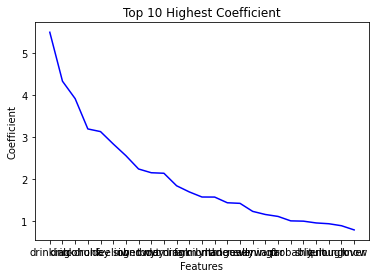

" \ncanvas = FigureCanvas(fig)\nimg = BytesIO()\nfig.savefig(img)\nimg.seek(0)\n\n#return send_file(img, mimetype='image/png)\n"

In [22]:
fig, ax = plt.subplots()

plt.plot(explanatory_words['features'], explanatory_words['coef'], color='blue')
#plt.plot(X, Y2, color='red')

plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Top 10 Highest Coefficient')
plt.show()

In [23]:
explanatory_words['features']

49     drinking
48        drink
0       alcohol
51        drunk
43          day
67      feeling
216       sober
110     iwndwyt
251       today
145     morning
47        drank
61       family
142       month
127        made
94     hangover
188      really
60      evening
269        want
66          far
181    probably
211        shit
184        quit
56       enough
103    hungover
111        know
Name: features, dtype: object